# Librerías

In [1]:
import numpy as np
import pandas as pd
import os
import re
from pandas.api.types import CategoricalDtype
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from datetime import datetime
import seaborn as sns
from google.colab import drive
from datetime import datetime, timedelta
import time

# Autorizar acceso a Google Drive
drive.mount("/content/drive")

# Métricas y Creación de Modelos TensorFlow y Keras
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, Conv2D, MaxPooling1D, MaxPooling2D , LSTM, Dense, Flatten, Dropout, LeakyReLU
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from keras.utils import to_categorical

# Librerías de Scikit-Learn
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.pipeline import Pipeline
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score, mean_absolute_error, r2_score, mean_squared_error
from sklearn.metrics import classification_report, confusion_matrix
import sklearn.metrics.pairwise
from sklearn.compose import ColumnTransformer
from sklearn.decomposition import PCA
import sklearn as sk

# Otras librerías de interés
from scipy.spatial.distance import pdist, squareform
from skimage.transform import resize
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import adfuller, acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tools.eval_measures import rmse

Mounted at /content/drive


In [2]:
def timing_decorator(func):
    def wrapper(*args, **kwargs):
        start_time = time.time()  # Tiempo de inicio
        result = func(*args, **kwargs)  # Ejecución de la función
        end_time = time.time()  # Tiempo de finalización
        print(f"Tiempo de ejecución de {func.__name__}: {end_time - start_time} segundos")
        return result
    return wrapper

# Conjunto de Datos

## Elegir un Dominio con Acceso a Datos

In [3]:
df = pd.read_csv("/content/drive/My Drive/Colab Notebooks/DCDC/data/weatherHistory.csv") # need to parse the dates

## EDA y Procesamiento de Datos

In [4]:
df.shape

(96453, 12)

In [5]:
df.info() # equivalente a df.isnull().sum()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 96453 entries, 0 to 96452
Data columns (total 12 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Formatted Date            96453 non-null  object 
 1   Summary                   96453 non-null  object 
 2   Precip Type               95936 non-null  object 
 3   Temperature (C)           96453 non-null  float64
 4   Apparent Temperature (C)  96453 non-null  float64
 5   Humidity                  96453 non-null  float64
 6   Wind Speed (km/h)         96453 non-null  float64
 7   Wind Bearing (degrees)    96453 non-null  float64
 8   Visibility (km)           96453 non-null  float64
 9   Loud Cover                96453 non-null  float64
 10  Pressure (millibars)      96453 non-null  float64
 11  Daily Summary             96453 non-null  object 
dtypes: float64(8), object(4)
memory usage: 8.8+ MB


In [6]:
df.head()

,Formatted Date,Summary,Precip Type,Temperature (C),Apparent Temperature (C),Humidity,Wind Speed (km/h),Wind Bearing (degrees),Visibility (km),Loud Cover,Pressure (millibars),Daily Summary
0,2006-04-01 00:00:00.000 +0200,Partly Cloudy,rain,9.472222,7.388889,0.89,14.1197,251.0,15.8263,0.0,1015.13,Partly cloudy throughout the day.
1,2006-04-01 01:00:00.000 +0200,Partly Cloudy,rain,9.355556,7.227778,0.86,14.2646,259.0,15.8263,0.0,1015.63,Partly cloudy throughout the day.
2,2006-04-01 02:00:00.000 +0200,Mostly Cloudy,rain,9.377778,9.377778,0.89,3.9284,204.0,14.9569,0.0,1015.94,Partly cloudy throughout the day.
3,2006-04-01 03:00:00.000 +0200,Partly Cloudy,rain,8.288889,5.944444,0.83,14.1036,269.0,15.8263,0.0,1016.41,Partly cloudy throughout the day.
4,2006-04-01 04:00:00.000 +0200,Mostly Cloudy,rain,8.755556,6.977778,0.83,11.0446,259.0,15.8263,0.0,1016.51,Partly cloudy throughout the day.


In [7]:
@timing_decorator
def impute_precip_type_na_as_snow(df):
    snow_conditions = ['Foggy', 'Overcast', 'Mostly Cloudy', 'Partly Cloudy',
                       'Breezy and Overcast', 'Breezy and Foggy', 'Breezy and Mostly Cloudy',
                       'Breezy and Partly Cloudy', 'Windy and Overcast', 'Windy and Foggy']

    rain_conditions = ['Rain', 'Light Rain', 'Drizzle', 'Heavy Rain']  # Ejemplo de condiciones de lluvia

    # Reglas para imputar nieve
    for index, row in df.iterrows():
        if pd.isna(row['Precip Type']):
            # R1: Condiciones de Summary para nieve
            if row['Summary'] in snow_conditions:
                # R2: Temperatura cercana o por debajo de 0°C
                if row['Temperature (C)'] <= 0:
                    df.at[index, 'Precip Type'] = 1  # Nieva
                # R3: Considerando estacionalidad (meses de invierno)
                elif row['Formatted Date'].month in [12, 1, 2]:
                    df.at[index, 'Precip Type'] = 1  # Nieva
            # R4: Condiciones de Summary para lluvia
            elif row['Summary'] in rain_conditions:
                df.at[index, 'Precip Type'] = 0  # Llueve
            # R5: Temperatura por encima de un umbral (ejemplo, 5 grados C)
            elif row['Temperature (C)'] > 5:
                df.at[index, 'Precip Type'] = 0  # Llueve

    # R6: Caso por defecto si ninguna condición se cumple --> Suposición por defecto: Llueve
    df['Precip Type'] = df['Precip Type'].fillna(0)
    return df

In [8]:
@timing_decorator
def preprocess_weather_data(df):
    # 0. Hacemos una copia del dataset para realizar las operaciones
    data = df.copy()

    # 1. Conversión de Fechas y Horas
    data['Formatted Date'] = pd.to_datetime(data['Formatted Date'], utc=True)

    # 2. Codificar valores categóricos de Precip Type y convertir las variables de tipo object a variables categóricas
    data['Precip Type'] = data['Precip Type'].map({'rain': 0, 'snow': 1})
    data['Summary'] = data['Summary'].astype(CategoricalDtype())
    data['Daily Summary'] = data['Daily Summary'].astype(CategoricalDtype())
    data['Precip Type'] = data['Precip Type'].astype(CategoricalDtype())

    # 3. Eliminar columna Cloud Cover por tener correlación igual a cero con las demás variables
    data = data.drop(['Loud Cover'], axis=1)

    # 4. Manejo de Valores Faltantes o N/A
    cleaned_data = impute_precip_type_na_as_snow(data)

    return cleaned_data

In [9]:
cleaned_data = preprocess_weather_data(df)

Tiempo de ejecución de impute_precip_type_na_as_snow: 8.496658325195312 segundos
Tiempo de ejecución de preprocess_weather_data: 10.674569129943848 segundos


In [10]:
cleaned_data.head()

,Formatted Date,Summary,Precip Type,Temperature (C),Apparent Temperature (C),Humidity,Wind Speed (km/h),Wind Bearing (degrees),Visibility (km),Pressure (millibars),Daily Summary
0,2006-03-31 22:00:00+00:00,Partly Cloudy,0.0,9.472222,7.388889,0.89,14.1197,251.0,15.8263,1015.13,Partly cloudy throughout the day.
1,2006-03-31 23:00:00+00:00,Partly Cloudy,0.0,9.355556,7.227778,0.86,14.2646,259.0,15.8263,1015.63,Partly cloudy throughout the day.
2,2006-04-01 00:00:00+00:00,Mostly Cloudy,0.0,9.377778,9.377778,0.89,3.9284,204.0,14.9569,1015.94,Partly cloudy throughout the day.
3,2006-04-01 01:00:00+00:00,Partly Cloudy,0.0,8.288889,5.944444,0.83,14.1036,269.0,15.8263,1016.41,Partly cloudy throughout the day.
4,2006-04-01 02:00:00+00:00,Mostly Cloudy,0.0,8.755556,6.977778,0.83,11.0446,259.0,15.8263,1016.51,Partly cloudy throughout the day.


In [11]:
cleaned_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 96453 entries, 0 to 96452
Data columns (total 11 columns):
 #   Column                    Non-Null Count  Dtype              
---  ------                    --------------  -----              
 0   Formatted Date            96453 non-null  datetime64[ns, UTC]
 1   Summary                   96453 non-null  category           
 2   Precip Type               96453 non-null  category           
 3   Temperature (C)           96453 non-null  float64            
 4   Apparent Temperature (C)  96453 non-null  float64            
 5   Humidity                  96453 non-null  float64            
 6   Wind Speed (km/h)         96453 non-null  float64            
 7   Wind Bearing (degrees)    96453 non-null  float64            
 8   Visibility (km)           96453 non-null  float64            
 9   Pressure (millibars)      96453 non-null  float64            
 10  Daily Summary             96453 non-null  category           
dtypes: category(3),

# Algoritmos de Data Mining

## Primer Enfoque: Clustering K-Means

In [12]:
@timing_decorator
def preprocess_data(data, numerical_cols, categorical_cols):
    preprocessor = ColumnTransformer(
        transformers=[
            ('num', StandardScaler(), numerical_cols),
            ('cat', OneHotEncoder(), categorical_cols)
        ])
    return preprocessor

@timing_decorator
def find_optimal_clusters(data, max_k):
    distortions = []
    for k in range(1, max_k + 1):
        kmeans = KMeans(n_clusters=k)
        kmeans.fit(data)
        distortions.append(kmeans.inertia_)

    plt.figure(figsize=(10, 6))
    plt.plot(range(1, max_k + 1), distortions, marker='o')
    plt.xlabel('Number of clusters')
    plt.ylabel('Distortion')
    plt.title('Elbow Method for Optimal K')
    plt.show()

@timing_decorator
def apply_kmeans(data, n_clusters, preprocessor):
    kmeans = KMeans(n_clusters=n_clusters)
    pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                               ('clusterer', kmeans)])
    pipeline.fit(data)
    return pipeline.named_steps['clusterer'].labels_

Tiempo de ejecución de preprocess_data: 4.38690185546875e-05 segundos


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


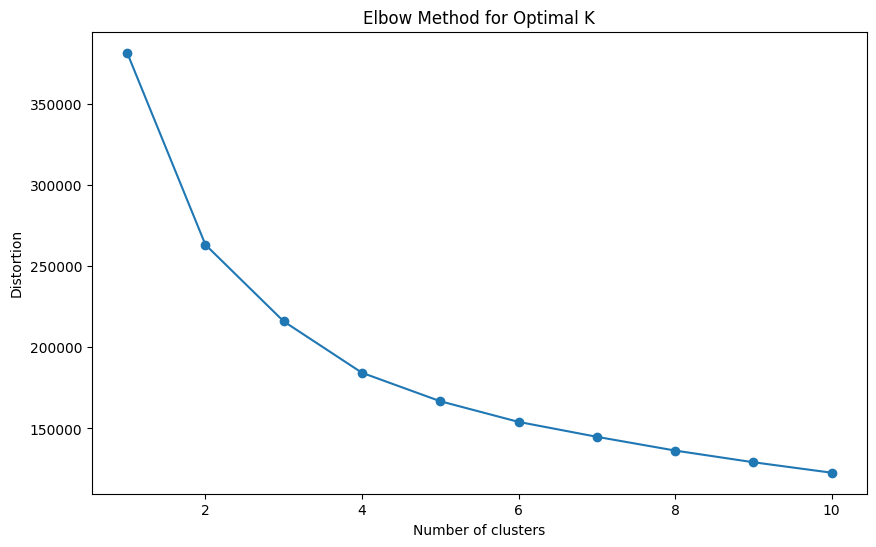

Tiempo de ejecución de find_optimal_clusters: 31.673123121261597 segundos


In [13]:
numerical_cols = ['Temperature (C)', 'Humidity', 'Wind Speed (km/h)']
categorical_cols = ['Summary', 'Precip Type']

preprocessor = preprocess_data(cleaned_data, numerical_cols, categorical_cols)
preprocessed_data = preprocessor.fit_transform(cleaned_data)

find_optimal_clusters(preprocessed_data, 10)  # Por ejemplo: probar hasta con 10 clusters

In [14]:
# Tras encontrar el número óptimo de clases
cluster_labels = apply_kmeans(cleaned_data, 10, preprocessor)
cleaned_data['Cluster'] = cluster_labels

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Tiempo de ejecución de apply_kmeans: 7.359816551208496 segundos


In [15]:
@timing_decorator
def visualize_clusters(data, cluster_column, numerical_cols, categorical_cols, n_components=2):
    # Preprocesado necesario
    preprocessor = ColumnTransformer(
        transformers=[
            ('num', StandardScaler(), numerical_cols),
            ('cat', OneHotEncoder(sparse=False), categorical_cols)  # Set sparse=False
        ])
    processed_data = preprocessor.fit_transform(data.drop(cluster_column, axis=1))

    # Aplicar PCA
    pca = PCA(n_components=n_components)
    components = pca.fit_transform(processed_data)

    # Crear un DataFrame para las componentes principales
    pca_df = pd.DataFrame(data=components, columns=[f'PC{i+1}' for i in range(n_components)])
    pca_df[cluster_column] = data[cluster_column].values  # Adding the cluster labels

    # Graficar los clusters en función de las componentes principales
    plt.figure(figsize=(10, 8))
    sns.scatterplot(data=pca_df, x='PC1', y='PC2', hue=cluster_column, palette='viridis')
    plt.title('Cluster Visualization with PCA')
    plt.savefig("kmeans.png")
    plt.show()

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


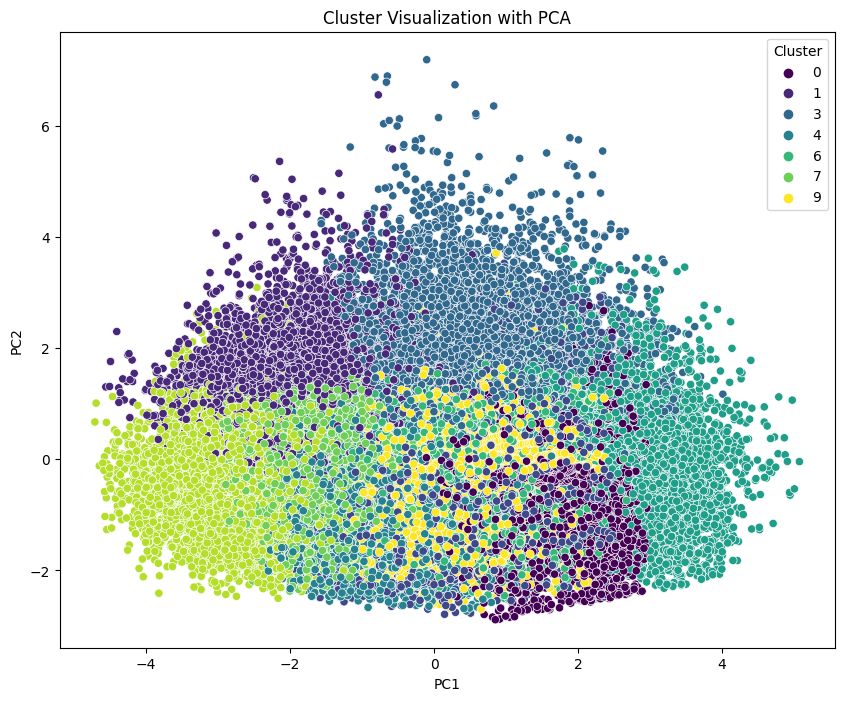

Tiempo de ejecución de visualize_clusters: 11.52285361289978 segundos


In [16]:
numerical_cols = ['Temperature (C)', 'Apparent Temperature (C)', 'Humidity',
                  'Wind Speed (km/h)', 'Wind Bearing (degrees)', 'Visibility (km)', 'Pressure (millibars)']
categorical_cols = ['Summary', 'Precip Type']

visualize_clusters(cleaned_data, 'Cluster', numerical_cols, categorical_cols)

In [17]:
from scipy.sparse import csr_matrix
from sklearn.metrics import pairwise_distances
@timing_decorator
def eval_clust(data, labels):
  # Convertir la matriz dispersa a densa
  dense_data = csr_matrix.toarray(data)
  silhouette = silhouette_score(dense_data, labels)
  db_index = davies_bouldin_score(dense_data, labels)
  ch_index = calinski_harabasz_score(dense_data, labels)

  #silhouette_avg = silhouette_score(data, labels)
  #kmeans = KMeans(n_clusters=n_clusters)
  #inertia = kmeans.inertia_
  #db_index = davies_bouldin_score(data, labels)
  #ch_index = calinski_harabasz_score(data, labels)

  print(f"Silhouette Score: {silhouette}")
  #print(f"Inertia: {inertia}")
  print(f"Davies-Bouldin Index: {db_index}")
  print(f"Calinski-Harabasz Index: {ch_index}")
eval_clust(preprocessed_data, cluster_labels)

Silhouette Score: 0.24863268572510983
Davies-Bouldin Index: 1.3249643058688423
Calinski-Harabasz Index: 22606.403402188687
Tiempo de ejecución de eval_clust: 124.6723804473877 segundos


## Segundo Enfoque: (S)ARIMA

In [18]:
@timing_decorator
def test_stationarity(timeseries):
    dftest = adfuller(timeseries, autolag='AIC')
    return dftest[1]  # p-value

@timing_decorator
def plot_acf_pacf(series):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12,4))
    plot_acf(series, ax=ax1)
    plot_pacf(series, ax=ax2)
    plt.show()

Tiempo de ejecución de test_stationarity: 30.016546964645386 segundos


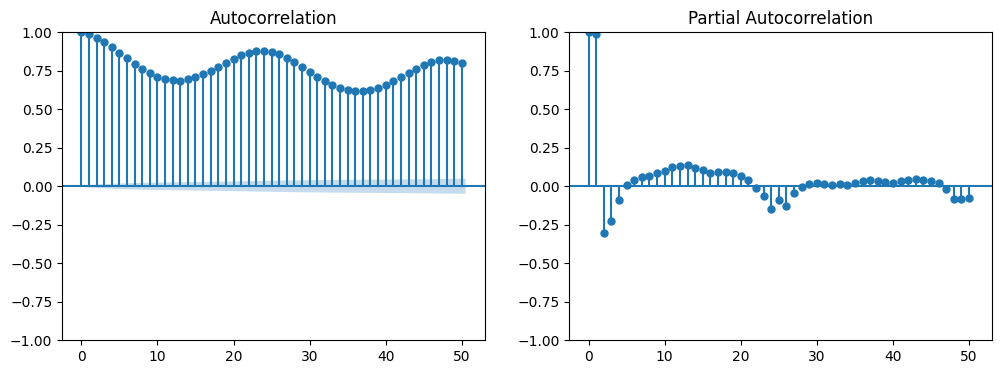

Tiempo de ejecución de plot_acf_pacf: 2.8989531993865967 segundos


In [19]:
p_value = test_stationarity(cleaned_data['Temperature (C)'])
if p_value > 0.05:
    # Apply differencing if not stationary
    cleaned_data['Temperature (C)'] = cleaned_data['Temperature (C)'].diff().dropna()

plot_acf_pacf(cleaned_data['Temperature (C)'])

In [20]:
@timing_decorator
def plot_seasonal_decompose(data, column_name, period):
    result = seasonal_decompose(data[column_name], model='additive', period=period)
    result.plot()
    plt.show()

@timing_decorator
def fit_sarima(data, column_name, order, seasonal_order):
    model = SARIMAX(data[column_name],
                    order=order,
                    seasonal_order=seasonal_order,
                    enforce_stationarity=False,
                    enforce_invertibility=False)
    results = model.fit()
    return results

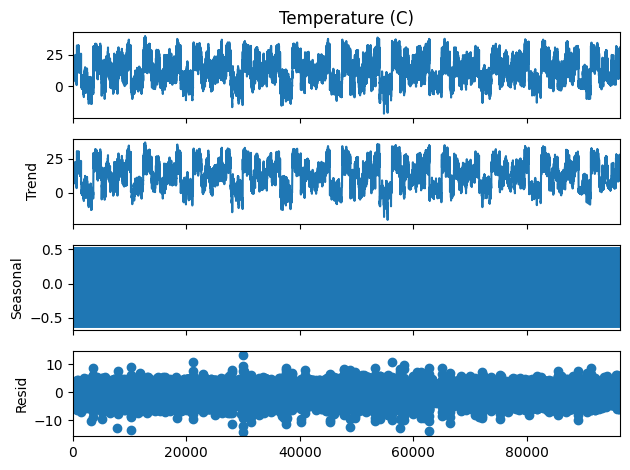

Tiempo de ejecución de plot_seasonal_decompose: 1.0268094539642334 segundos


In [21]:
plot_seasonal_decompose(cleaned_data, 'Temperature (C)', period=12)

In [22]:
sarima_results = fit_sarima(cleaned_data, 'Temperature (C)', order=(1, 1, 1), seasonal_order=(1, 1, 1, 12))

Tiempo de ejecución de fit_sarima: 87.4310417175293 segundos


In [23]:
print(sarima_results.summary())

                                     SARIMAX Results                                      
Dep. Variable:                    Temperature (C)   No. Observations:                96453
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 12)   Log Likelihood             -170110.458
Date:                            Thu, 21 Dec 2023   AIC                         340230.916
Time:                                    11:12:04   BIC                         340278.299
Sample:                                         0   HQIC                        340245.319
                                          - 96453                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.6793      0.008     84.961      0.000       0.664       0.695
ma.L1         -0.5153      0.009   

In [24]:
del sarima_results

In [25]:
@timing_decorator
def train_sarima(train_data, order, seasonal_order):
    model = SARIMAX(train_data,
                    order=order,
                    seasonal_order=seasonal_order,
                    enforce_stationarity=False,
                    enforce_invertibility=False)
    return model.fit()

@timing_decorator
def forecast_sarima(fitted_model, steps):
    return fitted_model.get_forecast(steps=steps)

@timing_decorator
def calculate_accuracy(test_data, predictions):
    mae = mean_absolute_error(test_data, predictions)
    mse = mean_squared_error(test_data, predictions)
    rmse_val = rmse(test_data, predictions)
    mape = np.mean(np.abs(test_data - predictions) / np.clip(np.abs(test_data), 0.1, None))

    return {'MAE': mae, 'MSE': mse, 'RMSE': rmse_val, 'MAPE': mape}

In [26]:
# Dividir conjunto de datos manualmente
train_size = int(len(cleaned_data) * 0.8)
train, test = cleaned_data.iloc[:train_size], cleaned_data.iloc[train_size:]

# Entrenar el modelo SARIMA
fitted_model = train_sarima(train['Temperature (C)'], (1, 1, 1), (1, 1, 1, 12))

# Predicción
forecast_results = forecast_sarima(fitted_model, len(test))
predictions = forecast_results.predicted_mean
conf_int = forecast_results.conf_int()

# Calcular métricas
accuracy_metrics = calculate_accuracy(test['Temperature (C)'], predictions)
for metric, value in accuracy_metrics.items():
    print(f'{metric}: {value}')

Tiempo de ejecución de train_sarima: 83.0420892238617 segundos
Tiempo de ejecución de forecast_sarima: 0.8856642246246338 segundos
Tiempo de ejecución de calculate_accuracy: 0.002769947052001953 segundos
MAE: 197.40309033069568
MSE: 50431.05124285565
RMSE: 224.56858917234095
MAPE: 62.68107320295024


## Tercer Enfoque: Random Forest Regressor

In [27]:
numerical_cols = ['Temperature (C)', 'Apparent Temperature (C)', 'Humidity',
                  'Wind Speed (km/h)', 'Wind Bearing (degrees)', 'Visibility (km)', 'Pressure (millibars)']
categorical_cols = ['Summary', 'Precip Type']

# Aplicar one-hot encoding a las columnas categóricas
df_encoded = pd.get_dummies(cleaned_data, columns=categorical_cols, drop_first=True)

# Crear un nuevo DataFrame solo con las columnas seleccionadas
df_numeric = df_encoded[numerical_cols + list(df_encoded.filter(regex='Summary|Precip Type').columns)]
df_numeric

,Temperature (C),Apparent Temperature (C),Humidity,Wind Speed (km/h),Wind Bearing (degrees),Visibility (km),Pressure (millibars),Daily Summary,Summary_Breezy and Dry,Summary_Breezy and Foggy,...,Summary_Overcast,Summary_Partly Cloudy,Summary_Rain,Summary_Windy,Summary_Windy and Dry,Summary_Windy and Foggy,Summary_Windy and Mostly Cloudy,Summary_Windy and Overcast,Summary_Windy and Partly Cloudy,Precip Type_1.0
0,9.472222,7.388889,0.89,14.1197,251.0,15.8263,1015.13,Partly cloudy throughout the day.,0,0,...,0,1,0,0,0,0,0,0,0,0
1,9.355556,7.227778,0.86,14.2646,259.0,15.8263,1015.63,Partly cloudy throughout the day.,0,0,...,0,1,0,0,0,0,0,0,0,0
2,9.377778,9.377778,0.89,3.9284,204.0,14.9569,1015.94,Partly cloudy throughout the day.,0,0,...,0,0,0,0,0,0,0,0,0,0
3,8.288889,5.944444,0.83,14.1036,269.0,15.8263,1016.41,Partly cloudy throughout the day.,0,0,...,0,1,0,0,0,0,0,0,0,0
4,8.755556,6.977778,0.83,11.0446,259.0,15.8263,1016.51,Partly cloudy throughout the day.,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
96448,26.016667,26.016667,0.43,10.9963,31.0,16.1000,1014.36,Partly cloudy starting in the morning.,0,0,...,0,1,0,0,0,0,0,0,0,0
96449,24.583333,24.583333,0.48,10.0947,20.0,15.5526,1015.16,Partly cloudy starting in the morning.,0,0,...,0,1,0,0,0,0,0,0,0,0
96450,22.038889,22.038889,0.56,8.9838,30.0,16.1000,1015.66,Partly cloudy starting in the morning.,0,0,...,0,1,0,0,0,0,0,0,0,0
96451,21.522222,21.522222,0.60,10.5294,20.0,16.1000,1015.95,Partly cloudy starting in the morning.,0,0,...,0,1,0,0,0,0,0,0,0,0


In [28]:
@timing_decorator
def categorizar(df):
  numerical_cols = ['Temperature (C)', 'Apparent Temperature (C)', 'Humidity',
                  'Wind Speed (km/h)', 'Wind Bearing (degrees)', 'Visibility (km)', 'Pressure (millibars)']
  categorical_cols = ['Summary', 'Precip Type']
  df_numeric = df[numerical_cols]

  encoder = OneHotEncoder(drop='first', sparse=False)
  df_encoded = pd.DataFrame(encoder.fit_transform(df[categorical_cols]), columns=encoder.get_feature_names_out(categorical_cols))

  df_result = pd.concat([df_numeric, df_encoded], axis=1)
  return df_result

@timing_decorator
def prepare_rf(df):
  X = df.drop('Temperature (C)', axis=1)
  y = df['Temperature (C)']
  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

  model_rf = RandomForestRegressor(n_estimators=100, random_state=42)
  model_rf.fit(X_train, y_train)
  return X_train, X_test, y_train, y_test, model_rf

@timing_decorator
def visualizar_pred_rf(X_train, X_test, y_train, y_test, model):
  y_pred = model.predict(X_test)
  # Visualizar las predicciones frente a los valores reales
  plt.scatter(y_test, y_pred)
  #plt.scatter(range(len(y_test)), y_test, color='red', label='Real')
  #plt.scatter(range(len(y_pred)), y_pred, color='blue', label='Predicho')

  plt.xlabel('Temperatura Real')
  plt.ylabel('Temperatura Predicha')
  plt.title('Comparación de Temperaturas Reales vs. Predichas')
  plt.show()

In [29]:
categorizar(cleaned_data)

Tiempo de ejecución de categorizar: 0.06724929809570312 segundos


/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


,Temperature (C),Apparent Temperature (C),Humidity,Wind Speed (km/h),Wind Bearing (degrees),Visibility (km),Pressure (millibars),Summary_Breezy and Dry,Summary_Breezy and Foggy,Summary_Breezy and Mostly Cloudy,...,Summary_Overcast,Summary_Partly Cloudy,Summary_Rain,Summary_Windy,Summary_Windy and Dry,Summary_Windy and Foggy,Summary_Windy and Mostly Cloudy,Summary_Windy and Overcast,Summary_Windy and Partly Cloudy,Precip Type_1.0
0,9.472222,7.388889,0.89,14.1197,251.0,15.8263,1015.13,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,9.355556,7.227778,0.86,14.2646,259.0,15.8263,1015.63,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,9.377778,9.377778,0.89,3.9284,204.0,14.9569,1015.94,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,8.288889,5.944444,0.83,14.1036,269.0,15.8263,1016.41,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,8.755556,6.977778,0.83,11.0446,259.0,15.8263,1016.51,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
96448,26.016667,26.016667,0.43,10.9963,31.0,16.1000,1014.36,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
96449,24.583333,24.583333,0.48,10.0947,20.0,15.5526,1015.16,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
96450,22.038889,22.038889,0.56,8.9838,30.0,16.1000,1015.66,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
96451,21.522222,21.522222,0.60,10.5294,20.0,16.1000,1015.95,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [30]:
df_result = categorizar(cleaned_data)
X_train, X_test, y_train, y_test, model_rf = prepare_rf(df_result)

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


Tiempo de ejecución de categorizar: 0.0724031925201416 segundos
Tiempo de ejecución de prepare_rf: 39.11017632484436 segundos


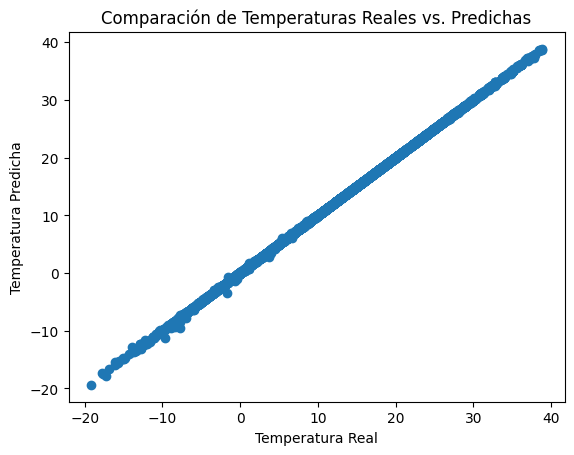

Tiempo de ejecución de visualizar_pred_rf: 0.9494025707244873 segundos


In [31]:
visualizar_pred_rf(X_train, X_test, y_train, y_test, model_rf)

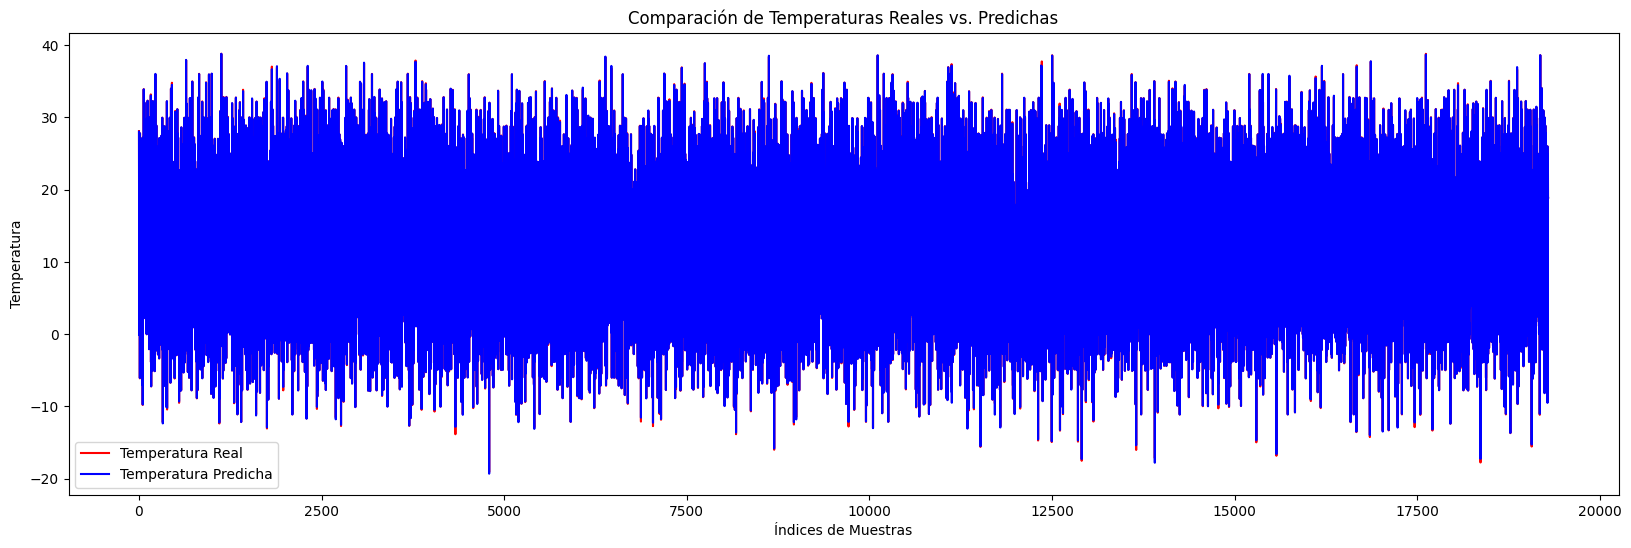

Tiempo de ejecución de visualizar_pred: 6.268718719482422 segundos


In [32]:
@timing_decorator
def visualizar_pred(X_train, X_test, y_train, y_test, model):
  y_pred = model.predict(X_test)
  indices = np.linspace(0, len(y_test), num=len(y_test)*100)
  plt.figure(figsize=(20, 6))
  plt.plot(indices, np.interp(indices, range(len(y_test)), y_test), color='red', label='Temperatura Real')
  plt.plot(indices, np.interp(indices, range(len(y_pred)), y_pred), color='blue', label='Temperatura Predicha')

  plt.xlabel('Índices de Muestras')
  plt.ylabel('Temperatura')
  plt.title('Comparación de Temperaturas Reales vs. Predichas')
  plt.legend()
  plt.show()

visualizar_pred(X_train, X_test, y_train, y_test, model_rf)

Mean Absolute Error: 0.012222467011105758
Mean Squared Error: 0.0019677081775804233
R-squared: 0.999978648831885


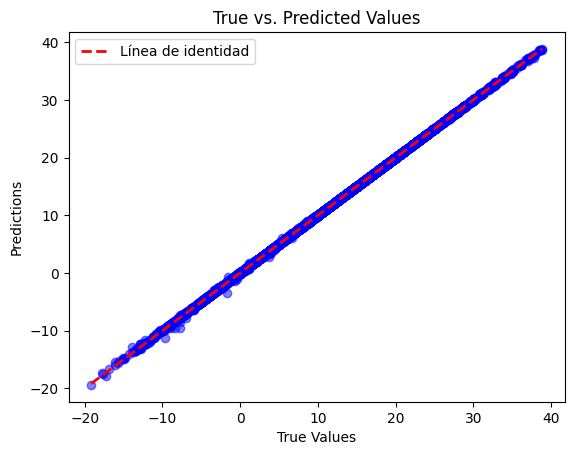

In [33]:
y_pred = model_rf.predict(X_test)
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f'Mean Absolute Error: {mae}')
print(f'Mean Squared Error: {mse}')
print(f'R-squared: {r2}')

plt.scatter(y_test, y_pred, color='blue', alpha=0.5)
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], linestyle='--', color='red', linewidth=2, label='Línea de identidad')
plt.xlabel('True Values')
plt.ylabel('Predictions')
plt.title('True vs. Predicted Values')
plt.legend()
plt.show()

In [34]:
@timing_decorator
def eval_model(X_train, X_test, y_train, y_test, model):
  y_pred = model_rf.predict(X_test)
  mae = mean_absolute_error(y_test, y_pred)
  mse = mean_squared_error(y_test, y_pred)
  r2 = r2_score(y_test, y_pred)
  rmse_val = rmse(y_test, y_pred)
  mape = np.mean(np.abs(y_test - y_pred) / np.clip(np.abs(y_test), 0.1, None))

  print(f'Mean Absolute Error: {mae}')
  print(f'Mean Squared Error: {mse}')
  print(f'RMSE: {rmse_val}')
  print(f'MAPE: {mape}')
  print(f'R-squared: {r2}')

  # Gráfica de dispersión
  plt.scatter(y_test, y_pred, color='blue', alpha=0.5)
  plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], linestyle='--', color='red', linewidth=2, label='Línea de identidad')
  plt.xlabel('True Values')
  plt.ylabel('Predictions')
  plt.title('True vs. Predicted Values')
  plt.legend()
  plt.show()

Mean Absolute Error: 0.012222467011105758
Mean Squared Error: 0.0019677081775804233
RMSE: 0.04435885681101828
MAPE: 0.007653277581416653
R-squared: 0.999978648831885


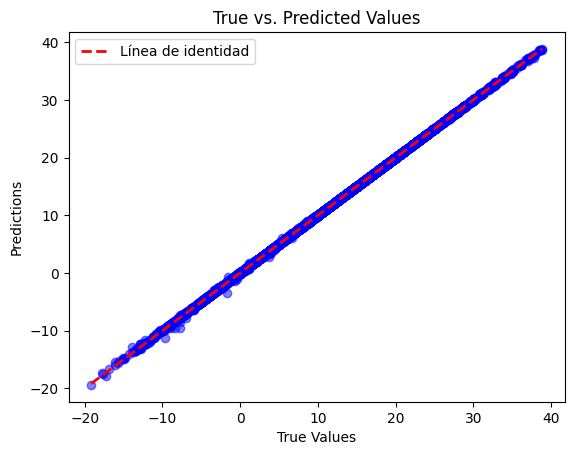

Tiempo de ejecución de eval_model: 0.9000368118286133 segundos


In [35]:
eval_model(X_train, X_test, y_train, y_test, model_rf)

## Cuarto Enfoque: CNN

In [36]:
@timing_decorator
def crear_series_temporales(df):
    if 'Formatted Date' in df.columns:
        df.set_index('Formatted Date', inplace=True)

    series_temporales = {}
    for column in df.columns:
        if pd.api.types.is_numeric_dtype(df[column]):
            # Resumen diario para columnas numéricas
            series_temporales[column] = df[column].resample('D').mean()
        else:
            # Para columnas categóricas, puedes decidir si deseas un resumen diario diferente
            # Por ahora, mantendremos la serie temporal original
            series_temporales[column] = df[column]

    return series_temporales

In [37]:
@timing_decorator
def recurrence_plot(s, eps=None, steps=None):
    if eps==None: eps=0.1
    if steps==None: steps=10
    d = sk.metrics.pairwise.pairwise_distances(s)
    d = np.floor(d / eps)
    d[d > steps] = steps
    #Z = squareform(d)
    return d

In [38]:
@timing_decorator
def preparar_datos(X,y):
  # Reshape para incluir profundidad
  X_train = X.reshape(X.shape[0], 1, 32,32)
  # Convertir a float32 y normalizar a [0,1]
  X_train = X_train.astype('float32')
  X_train /= np.amax(X_train)
  # Convertir labels a una matriz de clases, one-hot-encoding
  Y_train = to_categorical(y_train, 2)
  # Dividir en conjunto de entrenamiento (train) y de test
  X_train, x_test, Y_train, y_test = train_test_split(X_train, Y_train, test_size=0.1)
  return X_train, x_test, Y_train, y_test

In [39]:
@timing_decorator
def train_and_evaluar_model(model, train_X, train_label, test_X, test_Y_one_hot, batch_size, epochs, early_stopping):
    history = model.fit(
        train_X, train_label,
        batch_size=batch_size,
        epochs=epochs,
        verbose=0,
        callbacks=[early_stopping]
    )

    optimal_epochs = len(history.history['loss'])
    print("Número óptimo de épocas:", optimal_epochs)

    test_eval = model.evaluate(test_X, test_Y_one_hot, verbose=1)
    print('Test loss:', test_eval[0])
    print('Test accuracy:', test_eval[1])

    return history, test_eval

In [40]:
@timing_decorator
def build_model(input_shape, nClasses):
    model = Sequential()
    model.add(Conv2D(32, kernel_size=(3, 3), activation='linear', padding='same', input_shape=input_shape))
    model.add(LeakyReLU(alpha=0.1))
    model.add(MaxPooling2D((2, 2), padding='same'))
    model.add(Dropout(0.5))

    model.add(Flatten())
    model.add(Dense(32, activation='linear'))
    model.add(LeakyReLU(alpha=0.1))
    model.add(Dropout(0.5))
    model.add(Dense(nClasses, activation='softmax'))
    return model

In [41]:
@timing_decorator
def compile_model(model):
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    model.summary()
    return model

In [42]:
@timing_decorator
def setup_training(model, seed_value=13):
    early_stopping = keras.callbacks.EarlyStopping(
        monitor='val_loss',
        patience=5,
        restore_best_weights=True)

    np.random.seed(seed_value)
    tf.random.set_seed(seed_value)

    return model, early_stopping

In [43]:
@timing_decorator
def train_and_evaluate_model(model, train_X, train_label, valid_X, valid_label, test_X, test_Y_one_hot, batch_size, epochs, early_stopping):
    history = model.fit(
        train_X, train_label,
        batch_size=batch_size,
        epochs=epochs,
        verbose=0,
        validation_data=(valid_X, valid_label),
        callbacks=[early_stopping]
    )

    optimal_epochs = len(history.history['val_loss'])
    print("Número óptimo de épocas:", optimal_epochs)

    test_eval = model.evaluate(test_X, test_Y_one_hot, verbose=1)
    print('Test loss:', test_eval[0])
    print('Test accuracy:', test_eval[1])

    return history, test_eval

In [44]:
series_temporales = crear_series_temporales(cleaned_data)

Tiempo de ejecución de crear_series_temporales: 0.10472369194030762 segundos


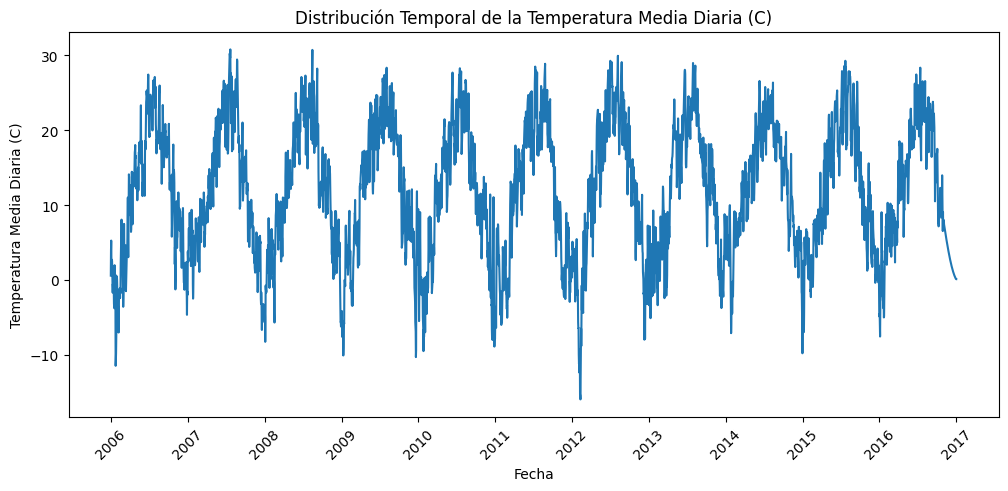

In [45]:
plt.figure(figsize=(12,5))
plt.plot(series_temporales["Temperature (C)"])
plt.title('Distribución Temporal de la Temperatura Media Diaria (C)')
plt.xlabel('Fecha')
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
plt.gca().xaxis.set_major_locator(mdates.YearLocator())
plt.ylabel('Temperatura Media Diaria (C)')
plt.xticks(rotation=45)
plt.show()

In [46]:
@timing_decorator
def plot_recurrence_plots(series_temporales):
    temp_a = series_temporales['Temperature (C)'].values
    wind_a = series_temporales['Wind Speed (km/h)'].values

    fig = plt.figure(figsize=(14, 15))
    ax1 = fig.add_subplot(1, 2, 1)
    ax1.imshow(recurrence_plot(temp_a[:, None], steps=100))

    ax2 = fig.add_subplot(1, 2, 2)
    ax2.imshow(recurrence_plot(wind_a[:, None], steps=100))
    plt.show()

In [47]:
@timing_decorator
def prepare_training_data(series_temporales, class_translate, shape=(32, 32)):
    x_train = np.zeros((384, shape[0], shape[1]))
    y_train = np.zeros(384)

    temp_rec = recurrence_plot(series_temporales['Temperature (C)'].values[:, None], steps=100)
    wind_rec = recurrence_plot(series_temporales['Wind Speed (km/h)'].values[:, None], steps=100)

    x_train[0, :, :] = resize(temp_rec, shape, mode='constant')
    y_train[0] = class_translate["temp"]
    x_train[1, :, :] = resize(wind_rec, shape, mode='constant')
    y_train[1] = class_translate["wind"]

    return x_train, y_train

Tiempo de ejecución de recurrence_plot: 0.3365907669067383 segundos
Tiempo de ejecución de recurrence_plot: 0.34803223609924316 segundos


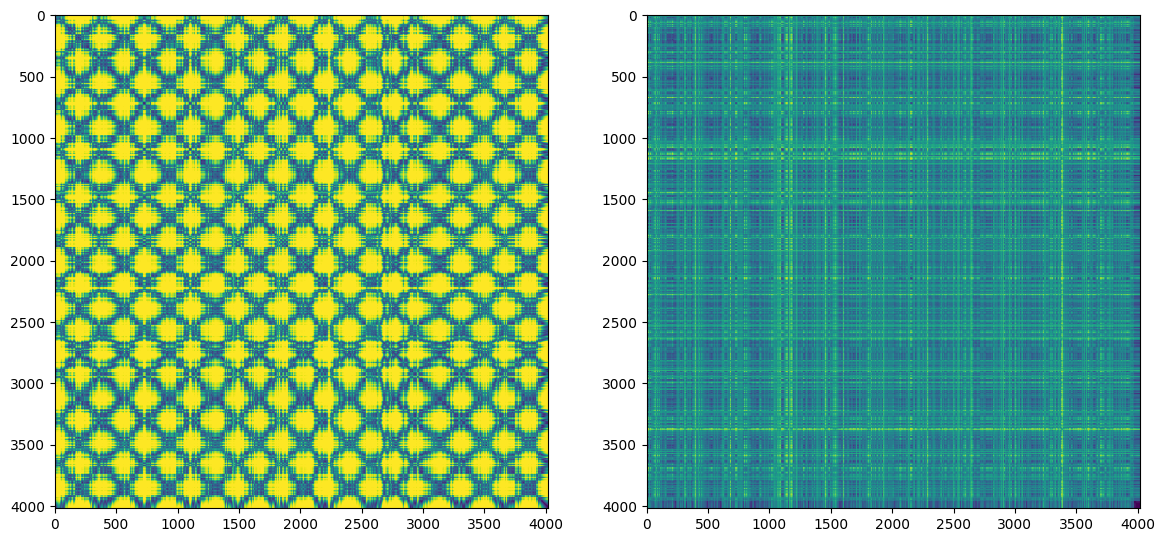

Tiempo de ejecución de plot_recurrence_plots: 3.4061408042907715 segundos


In [48]:
class_translate = {"temp": 0, "wind": 1}
plot_recurrence_plots(series_temporales)

In [49]:
x_train, y_train = prepare_training_data(series_temporales, class_translate)

Tiempo de ejecución de recurrence_plot: 0.516005277633667 segundos
Tiempo de ejecución de recurrence_plot: 0.464832067489624 segundos
Tiempo de ejecución de prepare_training_data: 22.822943210601807 segundos


In [50]:
X_train, x_test, Y_train, y_test = preparar_datos(x_train, y_train)

Tiempo de ejecución de preparar_datos: 0.0016472339630126953 segundos


In [51]:
# División en conjuntos de entrenamiento y prueba
print('Training data shape : ', X_train.shape, Y_train.shape)
print('Testing data shape : ', x_test.shape, y_test.shape)

Training data shape :  (345, 1, 32, 32) (345, 2)
Testing data shape :  (39, 1, 32, 32) (39, 2)


In [52]:
input_shape = (1,32,32)
nClasses = 2  # Asumiendo 2 clases (clasificación binaria)

model = build_model(input_shape, nClasses)
model = compile_model(model)
model, early_stopping = setup_training(model)
history, test_eval = train_and_evaluar_model(
    model, X_train, Y_train, x_test, y_test,
    batch_size=64, epochs=6, early_stopping=early_stopping
)

Tiempo de ejecución de build_model: 1.0622689723968506 segundos
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 1, 32, 32)         9248      
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 1, 32, 32)         0         
                                                                 
 max_pooling2d (MaxPooling2  (None, 1, 16, 32)         0         
 D)                                                              
                                                                 
 dropout (Dropout)           (None, 1, 16, 32)         0         
                                                                 
 flatten (Flatten)           (None, 512)               0         
                                                                 
 dense (Dense)               (None, 32)                164

Número óptimo de épocas: 6
2/2 [==============================] - 0s 96ms/step - loss: 0.1041 - accuracy: 1.0000
Test loss: 0.10410933941602707
Test accuracy: 1.0
Tiempo de ejecución de train_and_evaluar_model: 6.424972772598267 segundos
